# Demonstration of the fully-connected Vanilla GAN

#### Author: Peizhi Yan 
Date: 7/27/2020

In [1]:
#import tensorflow as tf                    # Tensorflow version 1
import tensorflow.compat.v1 as tf           # Tensorflow version 1 from version 2
tf.disable_v2_behavior()
import numpy as np                          # Numpy version 1.16.4
import matplotlib.pyplot as plt             # Matplotlib version 3.2.1
from tqdm import tqdm_notebook as tqdm

W0728 10:41:39.930031 40628 deprecation.py:323] From C:\Users\yanpe\AppData\Local\Programs\Python\Python36\lib\site-packages\tensorflow\python\compat\v2_compat.py:96: disable_resource_variables (from tensorflow.python.ops.variable_scope) is deprecated and will be removed in a future version.
Instructions for updating:
non-resource variables are not supported in the long term


### Load the MNIST dataset

x_train shape: (60000, 28, 28)
data shape: (5000, 784)


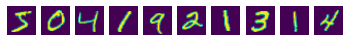

In [380]:
mnist_dataset = tf.keras.datasets.mnist
(x_train, _), _ = mnist_dataset.load_data() # only load training images
x_train = (x_train / 255.0)*2 - 1 # normalize the value to -1.0 ~ 1.0
print('x_train shape:', x_train.shape) # display the shape of training data

# display some samples
plt.figure()
for i in range(10):
    plt.subplot(1,10,i+1)
    plt.imshow(x_train[i])
    plt.axis('off')

# here I only take 5000 images
data = np.reshape(x_train, [-1, 28*28])[:5000]
print('data shape:', data.shape)

### Create the computational graph

In [393]:
def _create_generator_model(in_tensor, out_dim):
    with tf.variable_scope('generator'):
        h = tf.layers.dense(in_tensor, 128)
        h = tf.maximum(0.01*h, h) # LeakyReLU
        h = tf.layers.dropout(h, rate=0.2)
        g = tf.layers.dense(h, out_dim)
        g = tf.tanh(g)
    return g

def _create_discriminator_model(in_tensor, trainable=True):
    if trainable == True:
        scope = 'discriminator_A'
    else:
        scope = 'discriminator_B'
    with tf.variable_scope(scope):
        h = tf.layers.dense(in_tensor, 128)
        h = tf.maximum(0.01 * h, h) # LeakyReLU
        d = tf.layers.dense(h, 2)
    return d

In [394]:
tf.reset_default_graph()

# placeholders
x = tf.placeholder(dtype=tf.float32, shape=[None, 28*28], name="x") # image placeholder
y = tf.placeholder(dtype=tf.float32, shape=[None, 2], name='y') # label (True/Fake) placeholder
z = tf.placeholder(dtype = tf.float32, shape = [None, 100], name='z') # noise placeholder

# g: the generator output
g = _create_generator_model(in_tensor=z, out_dim=28*28)

# d: the output of the discriminator, used for training the discriminator 
d = _create_discriminator_model(in_tensor=x)

# d_gen: for training the generator in an end-to-end fasion
# the dummy discriminator will not be trained
d_ = _create_discriminator_model(in_tensor=g, trainable=False) # this is a dummy discriminator

# discriminator loss
loss_d = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = d, labels = y))

# generator loss
loss_g = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = d_, labels = y)) 

# optimizers
beta = 0.9
opt_d = tf.train.AdamOptimizer(0.001, beta).minimize(loss_d)
opt_g = tf.train.AdamOptimizer(0.001, beta).minimize(loss_g)

# create a graph to copy weights from discriminator A to B
copy_graph = []
d_weights = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope='discriminator_A')
d_weights_ = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope='discriminator_B')
for i in range(len(d_weights)):
    copy_graph.append(tf.assign(d_weights_[i], d_weights[i]))

# create the TF session and initialize the weights
sess = tf.Session()
sess.run(tf.global_variables_initializer())


In [395]:
def noise_generator(size, dim):
    # generate the random noize signal from a normal distribution
    return np.random.uniform(-1, 1, [size, dim]) 

### Train the GAN

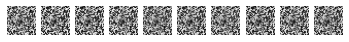

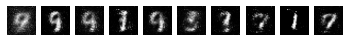

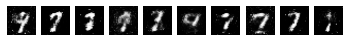

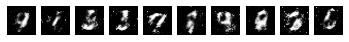

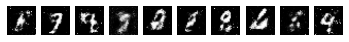

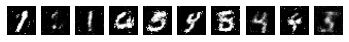

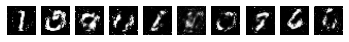

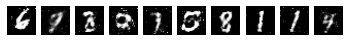

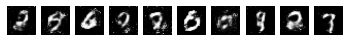

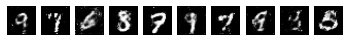

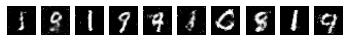

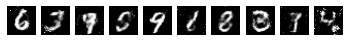

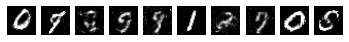

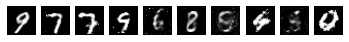

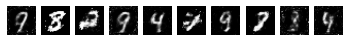

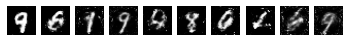

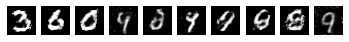

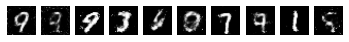

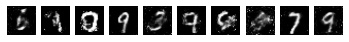

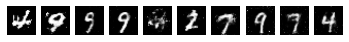

In [396]:
history = {'iter': [],
           'loss_g': [],
           'loss_d': []}

batch_size = 64
smooth_factor = 0.9
k = 1
for iteration in tqdm(range(2000)):
    idx = 0
    while idx < len(data):
        real_data = data[idx: idx + batch_size]
        
        # train the discriminator
        fake_data = sess.run(g, feed_dict={z: noise_generator(batch_size, 100)}) # generate a batch of fake data
        for _ in range(k):
            fuse_data = np.concatenate([fake_data, real_data]) # combine fake data with real data
            labels = np.full([len(fuse_data),2], 1 - smooth_factor)
            labels[:batch_size, 0] = smooth_factor
            labels[batch_size:, 1] = smooth_factor
            _, _loss_d = sess.run([opt_d, loss_d], feed_dict={x: fuse_data, y: labels})

        # train the generator
        sess.run(copy_graph) # copy the discriminator's weights to the frozen discriminator graph
        labels = np.full([batch_size, 2], 1 - smooth_factor)
        labels[:,1] = smooth_factor
        _, _loss_g = sess.run([opt_g, loss_g], feed_dict={z: noise_generator(batch_size, 100), 
                                                          y: labels})
    
        idx += batch_size
    
    # log history (I only used the last batch's loss :)
    history['iter'].append(iteration)
    history['loss_d'].append(_loss_d)
    history['loss_g'].append(_loss_g)
    
    # display 10 images every 100 iterations (epochs)
    if iteration % 100 == 0:
        _x = sess.run(g, feed_dict={z: noise_generator(10, 100)})
        for i in range(10):
            plt.subplot(1,10,i+1)
            plt.imshow(np.reshape(_x[i], [28,28]), cmap='gray')
            plt.axis('off')
        plt.show()

### Plot the loss history

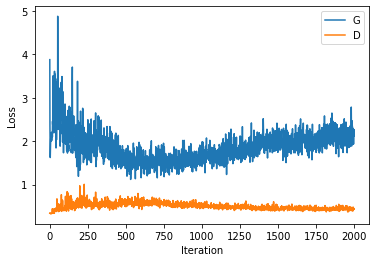

In [397]:
plt.plot(history['iter'], history['loss_g'], label='G')
plt.plot(history['iter'], history['loss_d'], label='D')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.legend()
plt.show()